In [82]:
import numpy as np
import pandas as pd 
import shutil
import random
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.utils.data import Dataset, Subset
from torchvision import transforms
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder
from math import *
import matplotlib.image as mpimg
import xml.etree.ElementTree as ET 
import cv2
from torchvision import transforms

%matplotlib inline

## Основная часть:
1) Изучить литературу, разобраться в том, как работают системы распознавания лиц
2) Выбрать и скачать датасет
3) Обучить нейросеть для распознавания лиц (третий из трех этапов пайплайна) на лицах, которые уже детектированы и заалайнены;
4) Реализовать метрику качества ID rate, проверить точность распознавания сетей из пунктов 3 и 4
5) Поставить эксперименты с разными лосс-функциями
6) Сделать выводы

Дополнительная часть:
1) Изучить разные лосс-функции: ArcFace, TripletLoss и другие. Обучить сеть с их помощью
2) Обучить сеть для элайна фото лиц.
3) Обучить свою сеть для детекции лиц на фото, собрать весь пайплайн из сетей для детекции, элайна и распознавания;
4) Исследовать литературу по распознаванию лиц, сделать обзор современных улучшений. Реализовать их на выбор.
5) Исследовать распределение выученных эмбеддингов лиц

### Критерии:
    Основная часть — 6 баллов:
    Обучение нейросети для распознавания лиц — 2 балла;
    Реализация метрики ID rate — 2 балла;
    Эксперименты с лосс-функциями — 2 балла;

### Дополнительные части:
    1-2 балла каждое, в зависимости от сложности.

Максимум по проекту можно будет получить 10 баллов.  

# Data loading

## Dataset for face Recognition task 

In [83]:
!kaggle datasets download -d atulanandjha/lfwpeople

Dataset URL: https://www.kaggle.com/datasets/atulanandjha/lfwpeople
License(s): GNU Lesser General Public License 3.0
100%|████████████████████████████████████████| 232M/232M [00:21<00:00, 11.7MB/s]
100%|████████████████████████████████████████| 232M/232M [00:21<00:00, 11.1MB/s]


In [84]:
import zipfile
import os

def extract_zip(zip_file_path, extract_to_dir):
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)
    
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to_dir)

zip_file_path = 'lfwpeople.zip'
extract_to_dir = 'Images'
extract_zip(zip_file_path, extract_to_dir)

In [85]:
import tarfile

def extract_tgz(tgz_file_path, extract_to_dir):
    if not os.path.exists(extract_to_dir):
        os.makedirs(extract_to_dir)
    
    with tarfile.open(tgz_file_path, "r:gz") as tar_ref:
        tar_ref.extractall(path=extract_to_dir)

tgz_file_path = 'Images/lfw-funneled.tgz'
extract_to_dir = 'Images'
extract_tgz(tgz_file_path, extract_to_dir)


## Test datasets preparation

In [86]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget http://dlib.net/files/data/ibug_300W_large_face_landmark_dataset.tar.gz
    !tar -xvzf 'ibug_300W_large_face_landmark_dataset.tar.gz'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.tar.gz'

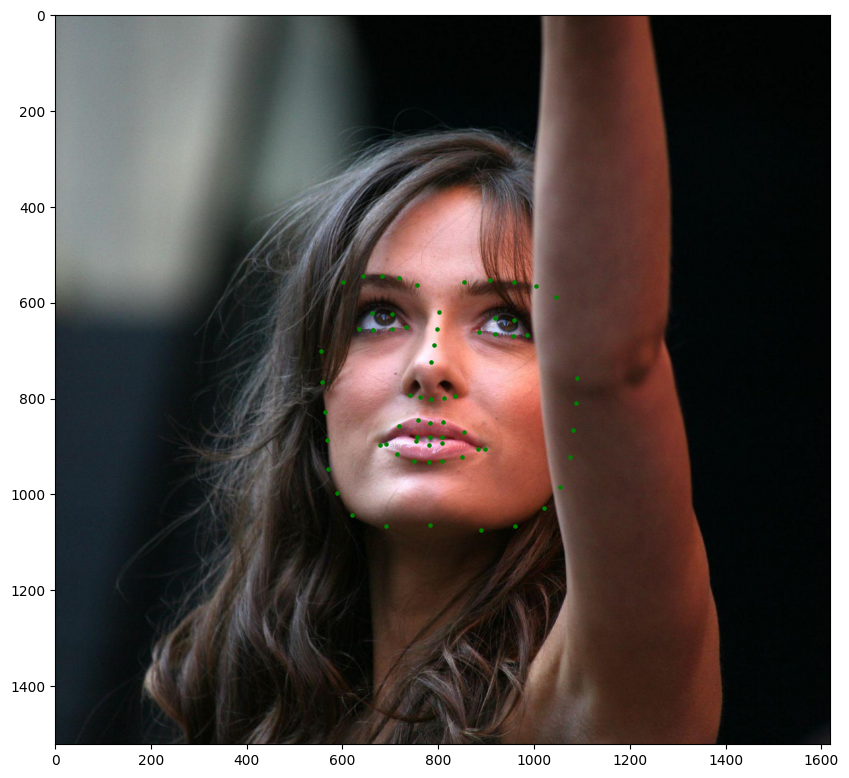

In [87]:
file = open('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.pts')
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread('ibug_300W_large_face_landmark_dataset/helen/trainset/100032540_1.jpg'))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [88]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = torch.tensor(random.uniform(-angle, +angle))

        transformation_matrix = torch.tensor([
            [+cos(radians(angle.item())), -sin(radians(angle.item()))],
            [+sin(radians(angle.item())), +cos(radians(angle.item()))]
        ])

        image = transforms.functional.rotate(image, angle.item())

        landmarks = landmarks - 0.5
        new_landmarks = torch.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return image, new_landmarks


    def resize(self, image, landmarks, img_size):
        image = transforms.functional.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3, 
                                              contrast=0.3,
                                              saturation=0.3, 
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = transforms.functional.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=10)
        
        image = transforms.functional.to_tensor(image)
        image = transforms.functional.normalize(image, [0.5], [0.5])
        return image, landmarks

In [89]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.root_dir = 'ibug_300W_large_face_landmark_dataset'
        
        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        crops = self.crops[index]
    
        if self.transform:
            image, landmarks = self.transform(image, landmarks, crops)
    
        landmarks = landmarks - 0.5

        return image, landmarks

train_dataset = FaceLandmarksDataset(Transforms())

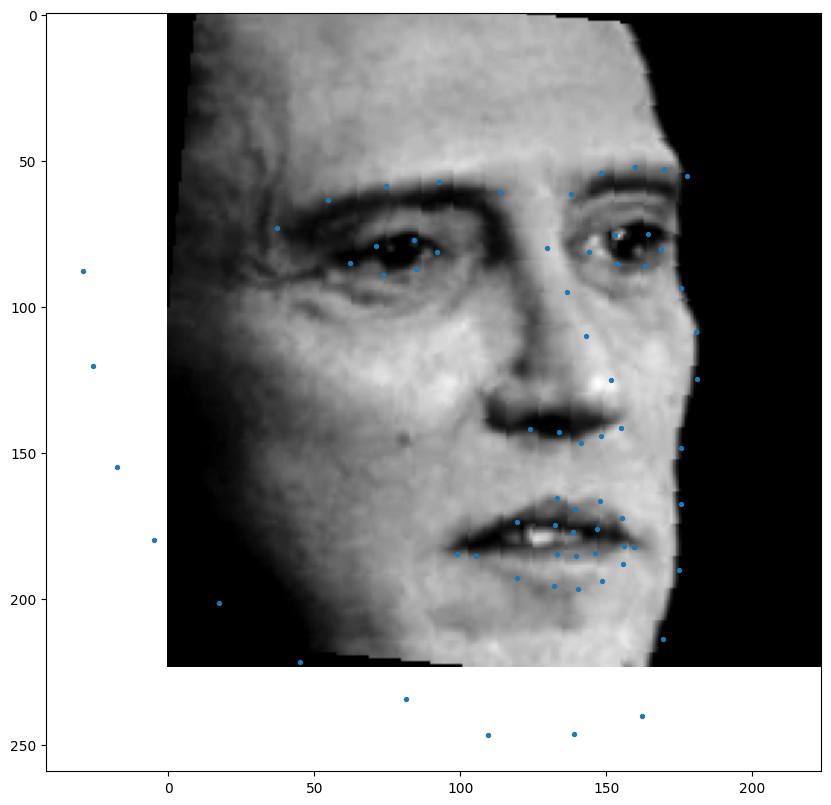

In [95]:
image, landmarks = train_dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

## Test datasets preparation

### Exclude people with less than 2 images

In [91]:
class FaceRecognitionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.images = []
        for class_ in self.classes:
            class_dir = os.path.join(root_dir, class_)
            if os.path.isdir(class_dir):
                class_images = [os.path.join(class_dir, img) for img in os.listdir(class_dir)]
                if len(class_images) >= 2:  # Only add the class if it has two or more images
                    self.images.extend([(img_path, class_) for img_path in class_images])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

In [92]:
test_dataset = FaceRecognitionDataset('Images/lfw_funneled')

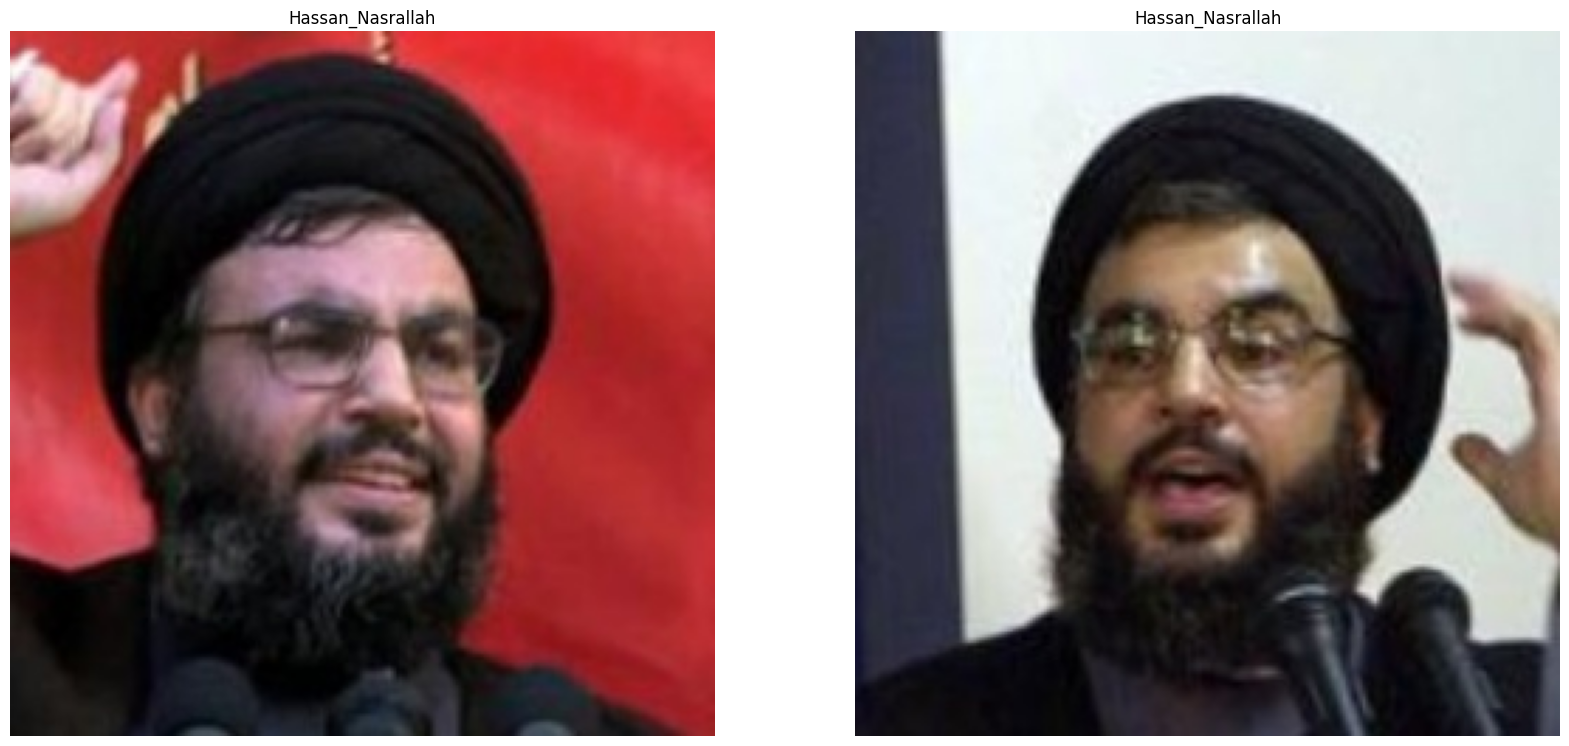

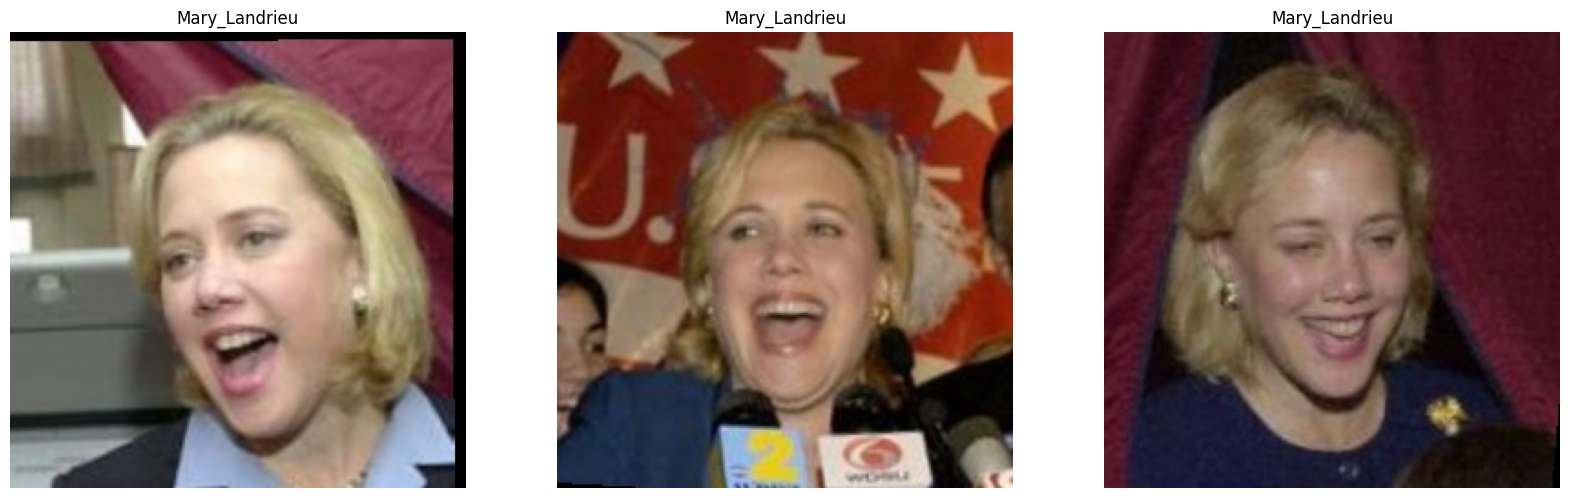

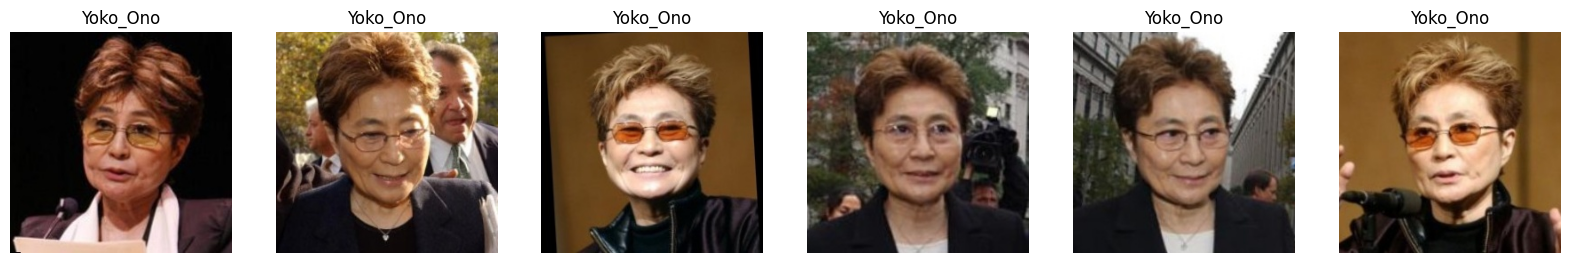

In [94]:
def visualize_images(dataset, num_people=3):
    # Get unique classes (people) in the dataset
    unique_classes = list(set([label for _, label in dataset.images]))

    # Select the first num_people classes
    selected_classes = unique_classes[:num_people]

    # For each selected class, get all images and display them
    for person in selected_classes:
        # Get all images of the current person
        images = [img for img, label in dataset.images if label == person]

        # Create a subplot for each image
        if len(images) == 1:
            fig, ax = plt.subplots(figsize=(5, 5))
            ax.imshow(Image.open(images[0]))
            ax.axis('off')
            ax.set_title(person)  # Add class label to the image
        else:
            fig, axs = plt.subplots(1, len(images), figsize=(20, 20))

            # Display each image
            for i, image in enumerate(images):
                axs[i].imshow(Image.open(image))
                axs[i].axis('off')
                axs[i].set_title(person)  # Add class label to the image

        plt.show()

# Use the function
visualize_images(test_dataset)

## Training of the alighment model